In [ ]:

plt.rcParams['figure.figsize'] = (10,5)
sns.set(style='whitegrid')

print('Data shape:', df.shape)
print(df[['comment_plain']].head(3))


Data shape: (6394, 11)
                                       comment_plain
0  om ded kaya seneng bangga bgttt lihat mereka b...
1  gila sabtu ini gue bahagia banget sheila dtg k...
2  salut sama keterbukaan dan kejujuran vidi shei...


In [ ]:
# Remove extremely short plain comments (e.g., 0 or 1 token) if they are noise.
min_tokens = 1  # set to 2 if you want stricter filtering
if 'token_len' in df.columns:
    before = len(df)
    df = df[df['token_len'] >= min_tokens].copy()
    print(f'Removed {before - len(df)} rows with token_len < {min_tokens}')
else:
    print('token_len column not found; skipping length filter.')


Removed 32 rows with token_len < 1


In [ ]:
# Choose ngram_range=(1,2) for more context; adjust min_df depending on corpus size.
vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=5,          # increase if vocabulary too large
    max_df=0.85,       # ignore extremely common terms
    sublinear_tf=True  # dampen impact of very frequent terms
)
X_tfidf = vectorizer.fit_transform(df['comment_plain'])
print('TF-IDF shape:', X_tfidf.shape)

TF-IDF shape: (6362, 3770)


k=6 silhouette=-0.0061
k=8 silhouette=0.0015
k=10 silhouette=0.0029
k=12 silhouette=0.0015

Best k by silhouette: 10


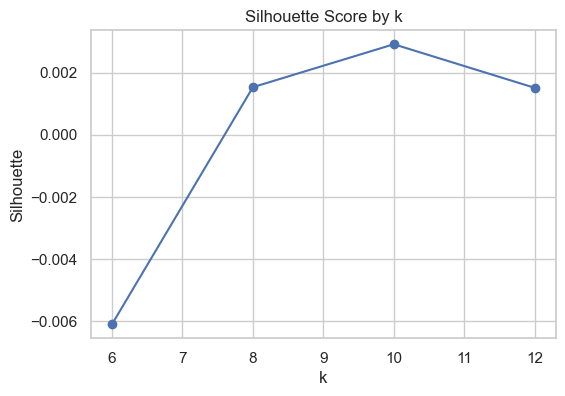

In [ ]:
candidate_k = [6,8,10,12]
sil_scores = {}
for k in candidate_k:
    km_tmp = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km_tmp.fit(X_tfidf)
    s = silhouette_score(X_tfidf, km_tmp.labels_)
    sil_scores[k] = s
    print(f'k={k} silhouette={s:.4f}')

best_k = max(sil_scores, key=sil_scores.get)
print('\nBest k by silhouette:', best_k)

# (Optional) Plot silhouette scores
plt.figure(figsize=(6,4))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.title('Silhouette Score by k')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.show()

In [ ]:
km = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
km.fit(X_tfidf)
df['cluster'] = km.labels_

terms = vectorizer.get_feature_names_out()
cluster_top_terms = {}
for c in range(best_k):
    center = km.cluster_centers_[c]
    top_idx = center.argsort()[-15:][::-1]
    top_terms = [terms[i] for i in top_idx]
    cluster_top_terms[c] = top_terms
    print(f'\nCluster {c} (n={ (df.cluster==c).sum() }):')
    print(top_terms)


Cluster 0 (n=1):
['nyaman banget', 'sejam', 'nyaa', 'banget nonton', 'nyaman', 'nonton', 'banget', 'gaze', 'gate', 'gausah', 'gaya', 'gelap', 'gede', 'gegara', 'gas']

Cluster 1 (n=5654):
['sheila', 'ini', 'di', 'banget', 'vidi', 'nonton', 'dan', 'film', 'yg', 'yang', 'sore', 'nya', 'sama', 'dara', 'ada']

Cluster 2 (n=37):
['bagus', 'bagus banget', 'banget', 'filmnya bagus', 'filmnya', 'film', 'ini bagus', 'ini', 'sore', 'sumpah', 'nyaa', 'film ini', 'bgtttt', 'nonton', 'bagus bgt']

Cluster 3 (n=1):
['dong sama', 'video', 'yandy laurens', 'ngobrol', 'laurens', 'dong', 'yandy', 'bikin', 'bang', 'sama', 'gede', 'gaze', 'gegara', 'gausah', 'gelap']

Cluster 4 (n=32):
['tika', 'tika bravani', 'bravani', 'sore', 'sheila', 'dara', 'meranin', 'bukan', 'sheila dara', 'wiyoko', 'kenapa', 'itu', 'di', 'yang', 'jadi sore']

Cluster 5 (n=48):
['laurens', 'yandy laurens', 'yandy', 'laurens we', 'we trust', 'yandi laurens', 'trust', 'karya', 'we', 'in yandy', 'in', 'yandi', 'film', 'sore', 'yg']


In [ ]:
cluster_map = {
    0: 'pujian_akting',
    1: 'kritik_alur',
    2: 'pertanyaan',
    3: 'pujian_visual',
    4: 'netral_umum',
    5: 'kritik_ending',
    # Add more / adjust if k > 6 or labels differ.
}

df['cluster_label'] = df['cluster'].map(cluster_map)

unmapped = df['cluster_label'].isna().sum()
if unmapped > 0:
    print(f'WARNING: {unmapped} rows have unmapped cluster labels. Update cluster_map!')
else:
    print('All clusters mapped to labels.')


In [ ]:
# Map thematic labels to coarse sentiment categories.
sentiment_map = {
    'pujian_akting': 'pos',
    'pujian_visual': 'pos',
    'kritik_alur': 'pos',
    'kritik_ending': 'neg',
    'pertanyaan': 'neu',
    'netral_umum': 'neu'
}

df['sentiment_cluster_based'] = df['cluster_label'].map(sentiment_map)
print(df[['comment_raw','cluster_label','sentiment_cluster_based']].head())


                                         comment_raw cluster_label  \
0  Om ded kaya seneng bangga bgttt lihat mereka b...   kritik_alur   
1  Gila sabtu ini gue bahagia banget,sheila dtg k...   kritik_alur   
2  Salut sama keterbukaan dan kejujuran Vidi & Sh...   kritik_alur   
3  Ya Allah, beri vidi kesehatan & panjang umur, ...   kritik_alur   
4  Dari awal cuma mau nonton iseng, eh malah dape...   kritik_alur   

  sentiment_cluster_based  
0                     pos  
1                     pos  
2                     pos  
3                     pos  
4                     pos  


In [ ]:
# (1) cluster-based labels, (2) existing rule-based labels (sentiment_label).
# Strategy: focus manual labeling later on mismatches. For now build a pseudo-labeled set.
if 'sentiment_label' in df.columns:
    df['rule_label'] = df['sentiment_label']
else:
    # If rule baseline not present, fall back to cluster-based only.
    df['rule_label'] = df['sentiment_cluster_based']

# Combine: use cluster label where available; fall back to rule label if cluster label missing.
df['pseudo_label'] = df['sentiment_cluster_based'].fillna(df['rule_label'])

# (Optional) Filter rows without any label
labeled_mask = df['pseudo_label'].isin(['pos','neg','neu'])
print('Pseudo-labeled rows:', labeled_mask.sum())
print(df['pseudo_label'].value_counts())

# Split train/test for supervised comparison.
X_supervised = X_tfidf[labeled_mask]
y_supervised = df.loc[labeled_mask,'pseudo_label']

X_train, X_test, y_train, y_test = train_test_split(
    X_supervised, y_supervised, test_size=0.2, random_state=42, stratify=y_supervised
)
print('Train size:', X_train.shape, 'Test size:', X_test.shape)


Pseudo-labeled rows: 5773
pseudo_label
pos    5656
neu      69
neg      48
Name: count, dtype: int64
Train size: (4618, 3770) Test size: (1155, 3770)


In [ ]:
log_clf = LogisticRegression(max_iter=400, class_weight='balanced')
log_clf.fit(X_train, y_train)
log_pred = log_clf.predict(X_test)
print('--- Logistic Regression Report ---')
print(classification_report(y_test, log_pred, digits=3))

--- Logistic Regression Report ---
              precision    recall  f1-score   support

         neg      0.833     1.000     0.909        10
         neu      0.929     0.929     0.929        14
         pos      0.999     0.997     0.998      1131

    accuracy                          0.997      1155
   macro avg      0.920     0.975     0.945      1155
weighted avg      0.997     0.997     0.997      1155



In [ ]:
# LinearSVC does not give probabilities directly; wrap with CalibratedClassifierCV if needed.
base_svm = LinearSVC(class_weight='balanced', max_iter=5000)
svm_clf = CalibratedClassifierCV(base_svm, cv=3)
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)
print('--- Linear SVM (Calibrated) Report ---')
print(classification_report(y_test, svm_pred, digits=3))


--- Linear SVM (Calibrated) Report ---
              precision    recall  f1-score   support

         neg      0.909     1.000     0.952        10
         neu      0.909     0.714     0.800        14
         pos      0.996     0.998     0.997      1131

    accuracy                          0.995      1155
   macro avg      0.938     0.904     0.917      1155
weighted avg      0.995     0.995     0.995      1155



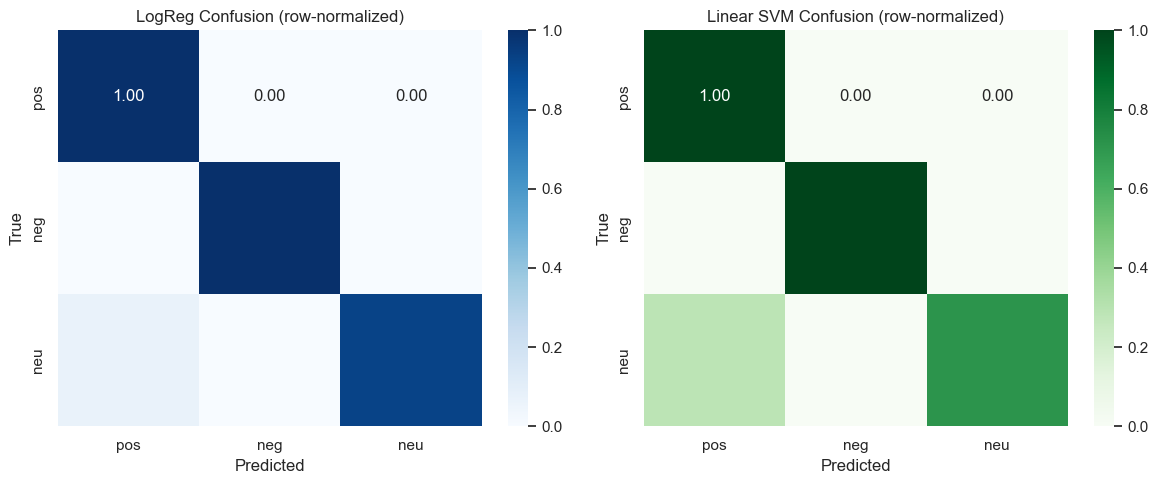

In [ ]:
labels_order = ['pos','neg','neu']
fig, axes = plt.subplots(1,2, figsize=(12,5))

cm_log = confusion_matrix(y_test, log_pred, labels=labels_order, normalize='true')
cm_svm = confusion_matrix(y_test, svm_pred, labels=labels_order, normalize='true')

sns.heatmap(cm_log, annot=True, cmap='Blues', xticklabels=labels_order, yticklabels=labels_order, ax=axes[0], fmt='.2f')
axes[0].set_title('LogReg Confusion (row-normalized)')

sns.heatmap(cm_svm, annot=True, cmap='Greens', xticklabels=labels_order, yticklabels=labels_order, ax=axes[1], fmt='.2f')
axes[1].set_title('Linear SVM Confusion (row-normalized)')

for ax in axes:
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
plt.tight_layout()
plt.show()

In [ ]:
df

,username,comment,username_raw,comment_raw,comment_clean,comment_plain,char_len,token_len,has_question,emoji_count,has_sheila,cluster,cluster_label,sentiment_cluster_based,rule_label,pseudo_label
0,@najmamld,Om ded kaya seneng bangga bgttt lihat mereka b...,@najmamld,Om ded kaya seneng bangga bgttt lihat mereka b...,om ded kaya seneng bangga bgttt lihat mereka b...,om ded kaya seneng bangga bgttt lihat mereka b...,212,35,False,0,True,1,kritik_alur,pos,pos,pos
1,@rezadimas3520,"Gila sabtu ini gue bahagia banget,sheila dtg k...",@rezadimas3520,"Gila sabtu ini gue bahagia banget,sheila dtg k...","gila sabtu ini gue bahagia banget,sheila dtg k...",gila sabtu ini gue bahagia banget sheila dtg k...,104,19,False,0,True,1,kritik_alur,pos,pos,pos
2,@Bahantoto_Official,Salut sama keterbukaan dan kejujuran Vidi & Sh...,@Bahantoto_Official,Salut sama keterbukaan dan kejujuran Vidi & Sh...,salut sama keterbukaan dan kejujuran vidi & sh...,salut sama keterbukaan dan kejujuran vidi shei...,215,31,False,0,True,1,kritik_alur,pos,pos,pos
3,@linarain8402,"Ya Allah, beri vidi kesehatan & panjang umur, ...",@linarain8402,"Ya Allah, beri vidi kesehatan & panjang umur, ...","ya allah, beri vidi kesehatan & panjang umur, ...",ya allah beri vidi kesehatan panjang umur krn ...,86,13,False,0,False,1,kritik_alur,pos,pos,pos
4,@DWV99-Khusus-Sultan,"Dari awal cuma mau nonton iseng, eh malah dape...",@DWV99-Khusus-Sultan,"Dari awal cuma mau nonton iseng, eh malah dape...","dari awal cuma mau nonton iseng, eh malah dape...",dari awal cuma mau nonton iseng eh malah dapet...,133,23,False,0,True,1,kritik_alur,pos,pos,pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10216,@danangari867,Ngak ada yg sempurna paling ngak 9 untuk pasan...,@danangari867,Ngak ada yg sempurna paling ngak 9 untuk pasan...,ngak ada yg sempurna paling ngak 9 untuk pasan...,ngak ada yg sempurna paling ngak 9 untuk pasan...,67,12,False,0,False,1,kritik_alur,pos,pos,pos
10722,@yohanajuniar2902,ternyata sama sama libra pantes ni 1 2 ngeseli...,@yohanajuniar2902,ternyata sama sama libra pantes ni 1 2 ngeseli...,ternyata sama sama libra pantes ni 1 2 ngeseli...,ternyata sama sama libra pantes ni 1 2 ngeseli...,50,9,False,0,False,1,kritik_alur,pos,pos,pos
11375,@Jerden25,Sore IDAMAN (Sore Istri DAri MAsa depaN) BOOM...,@Jerden25,Sore IDAMAN (Sore Istri DAri MAsa depaN) BOOM...,sore idaman (sore istri dari masa depan) boom!...,sore idaman sore istri dari masa depan boom be...,96,15,False,0,False,1,kritik_alur,pos,pos,pos
11376,@GooglenyaMasBintang,KEREN!,@GooglenyaMasBintang,KEREN!,keren!,keren,6,1,False,0,False,1,kritik_alur,pos,pos,pos
